Populating the interactive namespace from numpy and matplotlib


QhullError: QH6114 qhull precision error: initial simplex is not convex. Distance=-1.3

While executing:  | qhull d Qbb Qt Q12 Qz Qc
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1512611638  delaunay  Qbbound-last  Qtriangulate  Q12-no-wide-dup
  Qz-infinity-point  Qcoplanar-keep  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 2.4e+56  Error-roundoff 3.3e+41  _one-merge 2.3e+42
  Visible-distance 6.6e+41  U-coplanar-distance 6.6e+41  Width-outside 1.3e+42
  _wide-facet 4e+42

precision problems (corrected unless 'Q0' or an error)
      1 flipped facets

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p0(v3):    -1    -1 4.2e-57
- p400(v2): -6e+53 5.4e+53 2.4e+56
- p380(v1):     1    -1 4.2e-57
- p111(v0): -2.4e+56 2.2e+56 2.2e+56

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3.3e+41.  The center point, facets and distances
to the center point are as follows:

center point -5.97e+55 5.427e+55 1.137e+56

facet p400 p380 p111 distance= -1.1e+40
facet p0 p380 p111 distance= -4.2e+55
facet p0 p400 p111 distance= -1.1e+40
facet p0 p400 p380 distance= -5.4e+55

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:  -2.382e+56         1  difference= 2.382e+56
  1:        -1  2.165e+56  difference= 2.165e+56
  2:  2.211e-75  2.382e+56  difference= 2.382e+56

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 3.3e+41.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


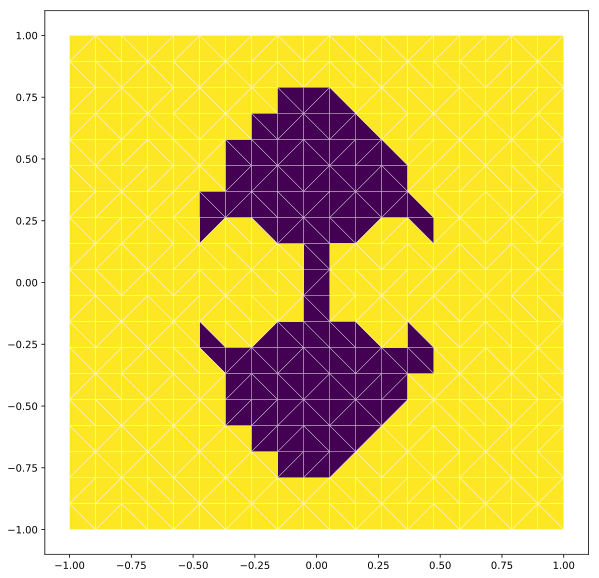

In [1]:
from numpy import linalg as LA
import numpy as np

import numpy.ma as ma

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'
%pylab inline
pylab.rcParams['figure.figsize']=(10,10)

def regGrid():
    pts = []
    n = 19
    h = 2/n
    for i in range(n+1):
        for j in range(n+1):
            pts.append([-1 + i*h, -1 + j*h])
    return pts
#Circle
#def u(v):
# return (v[0]**2 + v[1]**2)**0.5 - 0.8;

#dumbbell
def u(v):
    u1 = ((v[0] + 0.4)*(v[0] + 0.4) + v[1]*v[1])**0.5 - 0.9
    u2 = ((v[0] - 0.4)*(v[0] - 0.4) + v[1]*v[1])**0.5 - 0.9
    u3 = ((v[0] + 0.3)*(v[0] + 0.3) + v[1]*v[1])**0.5 - 0.25
    u4 = ((v[0] - 0.3)*(v[0] - 0.3) + v[1]*v[1])**0.5 - 0.25
    #u5 = (v[0]**100 + v[1]**100)**0.01 - 1
    return -min(-max(u1, u2), min(u3, u4));

def du(v):
    t = 0.01
    res = [0, 0]
    res[0] = (u([v[0] + t, v[1]]) - u([v[0] - t, v[1]]))/(2*t)
    res[1] = (u([v[0], v[1] + t]) - u([v[0], v[1] - t]))/(2*t)
    return res

def project(vert, vmask):
    e = 0.00000001
    t1 = 1
    v = vert
    uxy = np.array(du(v))
    if vmask == 2 or abs(v[0])> 1 or abs(v[1])> 1:
        if v[0] > 1:
            v[0] = 1
        if v[0] < -1:
            v[0] = -1
        if v[1] > 1:
            v[1] = 1
        if v[1] < -1:
            v[1] = -1
        return v
    else:
        i = 0
        while abs(u(v)) > e*LA.norm(uxy) and i<200:
            v = np.array(v) - t1*u(v)/LA.norm(uxy)*uxy
            i+=1
        return v

def initMask(pts):
    vmask = np.sign([u(x) for x in pts])
    return vmask

def located(pt):
    if (u(pt) < 0.0001):
        return 1
    else:
        return 2

def findBorder(tri, pts):
    edgeIn = set()
    edgeOut = set()
    border = set()
    for x in range(len(tri)):
        if tri[x][0] < tri[x][1]:
            e1 = (tri[x][0], tri[x][1])
        else:
            e1 = (tri[x][1], tri[x][0])
        if tri[x][0] < tri[x][2]:
            e2 = (tri[x][0], tri[x][2])
        else:
            e2 = (tri[x][2], tri[x][0])
        if tri[x][2] < tri[x][1]:
            e3 = (tri[x][2], tri[x][1])
        else:
            e3 = (tri[x][1],tri[x][2])
        if trimask[x] == 1:
            edgeIn.add(e1)
            edgeIn.add(e2)
            edgeIn.add(e3)
        else:
            edgeOut.add(e1)
            edgeOut.add(e2)
            edgeOut.add(e3)

    border = edgeIn.intersection(edgeOut)
    L = 0
    for x in edgeIn:
        L += LA.norm(pts[x[0]]- pts[x[1]])**2
    inL0 = (L/len(edgeIn))**0.5
    L = 0
    for x in edgeOut:
        L += LA.norm(pts[x[0]]- pts[x[1]])**2
    outL0 = (L/len(edgeOut))**0.5
    return inL0,outL0, edgeIn, edgeOut, border

def formForces(edgeIn, edgeOut, pts, inL0, outL0):
    Mconst = 1.2
    edges = edgeIn.union(edgeOut)
    F1 = np.zeros(( len(pts), 2))
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        L = LA.norm(pts[p1] - pts[p2])
        if L < 0.000001:
            L = 0.000001
        if vmask[p1] == -1:
            L0 = inL0
        else:
            L0 = outL0
        F1[p1] -= Mconst*(1.0 - L0 / L)*L0 / L*(pts[p1] - pts[p2])
        F1[p2] -= Mconst*(1.0 - L0 / L)*L0 / L*(pts[p2] - pts[p1])
    return F1

def moveMesh(pts, F1):
    t = 0.1
    toProj = set()
    for x in range(len(pts)):
        if t*LA.norm(F1[x]) > inL0/2:
            pts[x] = pts[x] + inL0/2*F1[x]/LA.norm(F1[x])
        else:
            pts[x] = pts[x] + t*F1[x]
        if (vmask[x] == 2 and (abs(pts[x][0]) > 1 or abs(pts[x][1]) > 1)) or vmask[x] == 0:
            toProj.add(x)
    return toProj

#регулярная сетка, Делоне
points = regGrid()
points = np.array(points)
vmask = initMask(points)

for i in range(2):

    tri = Delaunay(points)
            
    #удалить треугольники за пределами области

    index2point = lambda index: tri.points[index]
    all_centers = index2point(tri.vertices)
    insideBox = [(abs(item.mean(axis=0)[0]) < 0.999 and abs(item.mean(axis=0)[1]) < 0.999) for item in all_centers]
    faces=tri.simplices[np.where(insideBox)]

    #Маска треугольников
    all_centers = index2point(faces)
    trimask = np.array([located(item.mean(axis=0)) for item in all_centers])
    
    #Рисуем
    plt.figure()
    plt.gca().set_aspect('equal')
    plt.tripcolor(points[:,0], points[:,1], faces, facecolors=trimask, edgecolors='w')
    if i%5 == 0:
        fname = str(i) + 'dumbbell.png'
        savefig(fname, bbox_inches='tight')
    #plt.show()

    #Внешняя граница
    for x in tri.convex_hull:
        vmask[x[0]] = 2;
        vmask[x[1]] = 2;
    
    #Найдем границу и L0 внутри и снаружи
    inL0,outL0, edgeIn, edgeOut, border = findBorder(faces, points)
    for x in border:
        vmask[x[0]] = 0;
        vmask[x[1]] = 0;
            
    #считаем силы
    
    F1 = formForces(edgeIn, edgeOut, points, inL0, outL0)
            
    #двигаем силы и проецируем границу
    toProj = moveMesh(points, F1)
    for p in toProj:
        points[p] = project(points[p], vmask[p])